# Accident Risk Prediction 

**Project Goal:** Predict accident risk (continuous value 0-1) based on road and traffic conditions.

**Dataset:** Simulated Roads Accident dataset from Kaggle

## 1. Setup and Data Loading

In [1]:
# Import libraries
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    HuberRegressor,
    Lasso,
    LinearRegression,
    RANSACRegressor,
    Ridge,
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from xgboost import XGBRegressor

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.float_format", "{:.4f}".format)

# Static variables
RANDOM_STATE = 42
N_ITER_GRID_SEARCH = 3  # low value for quicker testing in local environment
CV_GRID_SEARCH = 3

# Load datasets
train_df = pd.read_csv("../data/train.csv", index_col="id")
kaggle_test_df = pd.read_csv("../data/test.csv", index_col="id")

## 2. Initial Data Exploration

In [2]:
# Shape of datasets
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {kaggle_test_df.shape}")

# Display first rows of training set
train_df.head()

Training set shape: (517754, 13)
Test set shape: (172585, 12)


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.0600,35,daylight,rainy,False,True,afternoon,False,True,1,0.1300
1,urban,4,0.9900,35,daylight,clear,True,False,evening,True,True,0,0.3500
2,rural,4,0.6300,70,dim,clear,False,True,morning,True,False,2,0.3000
3,highway,4,0.0700,35,dim,rainy,True,True,morning,False,False,1,0.2100
4,rural,1,0.5800,60,daylight,foggy,False,False,evening,True,False,1,0.5600


In [3]:
# Basic information about the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [4]:
# Statistical summary
train_df.describe(include="all")

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
count,517754,517754.0000,517754.0000,517754.0000,517754,517754,517754,517754,517754,517754,517754,517754.0000,517754.0000
unique,3,NaN,NaN,NaN,3,3,2,2,3,2,2,NaN,NaN
top,highway,NaN,NaN,NaN,dim,foggy,False,True,morning,True,False,NaN,NaN
freq,173672,NaN,NaN,NaN,183826,181463,259289,260045,173410,260688,260164,NaN,NaN
mean,NaN,2.4915,0.4887,46.1126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1880,0.3524
std,NaN,1.1204,0.2726,15.7885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8960,0.1664
min,NaN,1.0000,0.0000,25.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000
25%,NaN,1.0000,0.2600,35.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.2300
50%,NaN,2.0000,0.5100,45.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.3400
75%,NaN,3.0000,0.7100,60.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0000,0.4600


In [5]:
# Check for missing values
train_df.isnull().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


Target Variable (accident_risk) Statistics:
count   517754.0000
mean         0.3524
std          0.1664
min          0.0000
25%          0.2300
50%          0.3400
75%          0.4600
max          1.0000
Name: accident_risk, dtype: float64


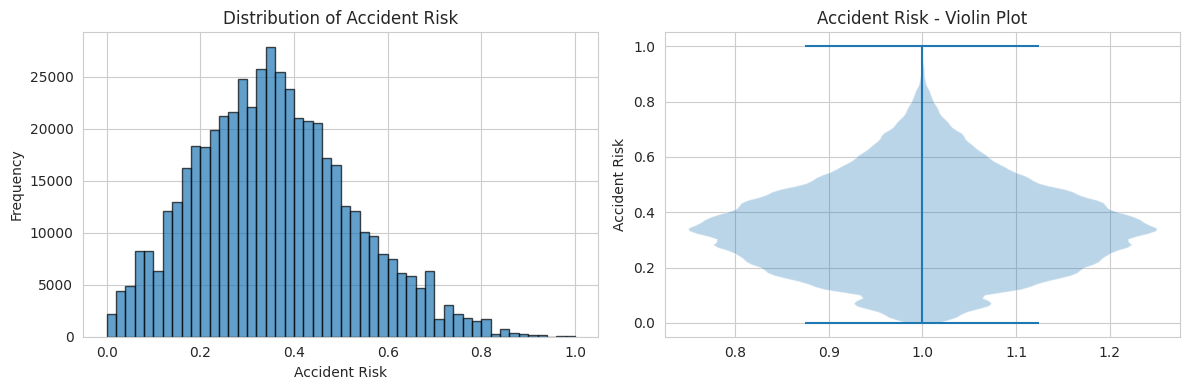

In [6]:
# Target variable distribution
print("\nTarget Variable (accident_risk) Statistics:")
print(train_df["accident_risk"].describe())

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_df["accident_risk"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Accident Risk")
plt.ylabel("Frequency")
plt.title("Distribution of Accident Risk")

plt.subplot(1, 2, 2)
plt.violinplot(train_df["accident_risk"])
plt.ylabel("Accident Risk")
plt.title("Accident Risk - Violin Plot")

plt.tight_layout()
plt.show()

## 3. Feature Analysis

In [7]:
# Separate features and target
X = train_df.drop("accident_risk", axis=1)
y = train_df["accident_risk"]

# Identify feature types
numerical_features = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents"]
categorical_features = ["road_type", "lighting", "weather", "time_of_day"]
boolean_features = ["road_signs_present", "public_road", "holiday", "school_season"]

print(f"Total features: {len(X.columns)}")
print(f"Numerical: {len(numerical_features)}")
print(f"Categorical: {len(categorical_features)}")
print(f"Boolean: {len(boolean_features)}")
print(f"\nTarget variable range: [{y.min():.2f}, {y.max():.2f}]")

Total features: 12
Numerical: 4
Categorical: 4
Boolean: 4

Target variable range: [0.00, 1.00]


## 4. Data Splitting

In [8]:
# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

print("Data split:")
print(f"  Train:      {X_train.shape[0]:>6} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]:>6} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:       {X_test.shape[0]:>6} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Data split:
  Train:      362427 samples (70.0%)
  Validation:  77663 samples (15.0%)
  Test:        77664 samples (15.0%)


## 5. Data Preprocessing

In [9]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features),
        ("bool", "passthrough", boolean_features),
    ],
    remainder="drop",
)

# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
X_kaggle_processed = preprocessor.transform(kaggle_test_df)

print(f"Original features: {X_train.shape[1]}")
print(f"After preprocessing: {X_train_processed.shape[1]}")

Original features: 12
After preprocessing: 16


## 6. Manual Model Comparison with choosen Algorithms

In [10]:
# Define light and fast models to evaluate
models = {
    # Linear Models
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE),
    "ElasticNet": ElasticNet(random_state=RANDOM_STATE),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "RANSAC": RANSACRegressor(random_state=RANDOM_STATE),
    
    # Tree - based models
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    # "RandomForest": RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1),
    
    # Gradient Boosting Models
    "XGBoost": XGBRegressor(n_estimators=50, random_state=RANDOM_STATE, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=50, random_state=RANDOM_STATE, verbose=-1),
    
    # Ensemble Methods

    "Bagging": BaggingRegressor(n_estimators=10, random_state=RANDOM_STATE, n_jobs=-1),
    
    # Other Fast Models
    "PLSRegression": PLSRegression(n_components=2),
}

results = []
trained_models = {}

# Minimalist tqdm without emojis
for name, model in tqdm(models.items(), desc="Training models"):
    start_time = time.time()

    # Train model
    model.fit(X_train_processed, y_train)

    # Store the trained model
    trained_models[name] = model

    # Predict on validation set
    y_pred = model.predict(X_val_processed)

    # Calculate metrics
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    training_time = time.time() - start_time

    # Store results
    results.append({"Model": name, "R-Squared": r2, "RMSE": rmse, "MAE": mae, "Time (s)": training_time})


# Create results dataframe
results_df = pd.DataFrame(results).sort_values("R-Squared", ascending=False).reset_index(drop=True)

Training models: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Model performance comparison and vizualisation

In [11]:
display(results_df)

,Model,R-Squared,RMSE,MAE,Time (s)
0,XGBoost,0.8845,0.0565,0.0438,0.7538
1,LightGBM,0.8832,0.0568,0.0441,0.8011
2,Bagging,0.8594,0.0623,0.0483,4.4821
3,LinearRegression,0.8035,0.0737,0.0584,0.1884
4,Ridge,0.8035,0.0737,0.0584,0.1270
5,BayesianRidge,0.8035,0.0737,0.0584,0.3554
6,HuberRegressor,0.8034,0.0737,0.0583,2.9095
7,PLSRegression,0.7892,0.0763,0.0607,0.2468
8,DecisionTree,0.7478,0.0834,0.0642,2.2954
9,RANSAC,0.6798,0.0940,0.0732,1.9127


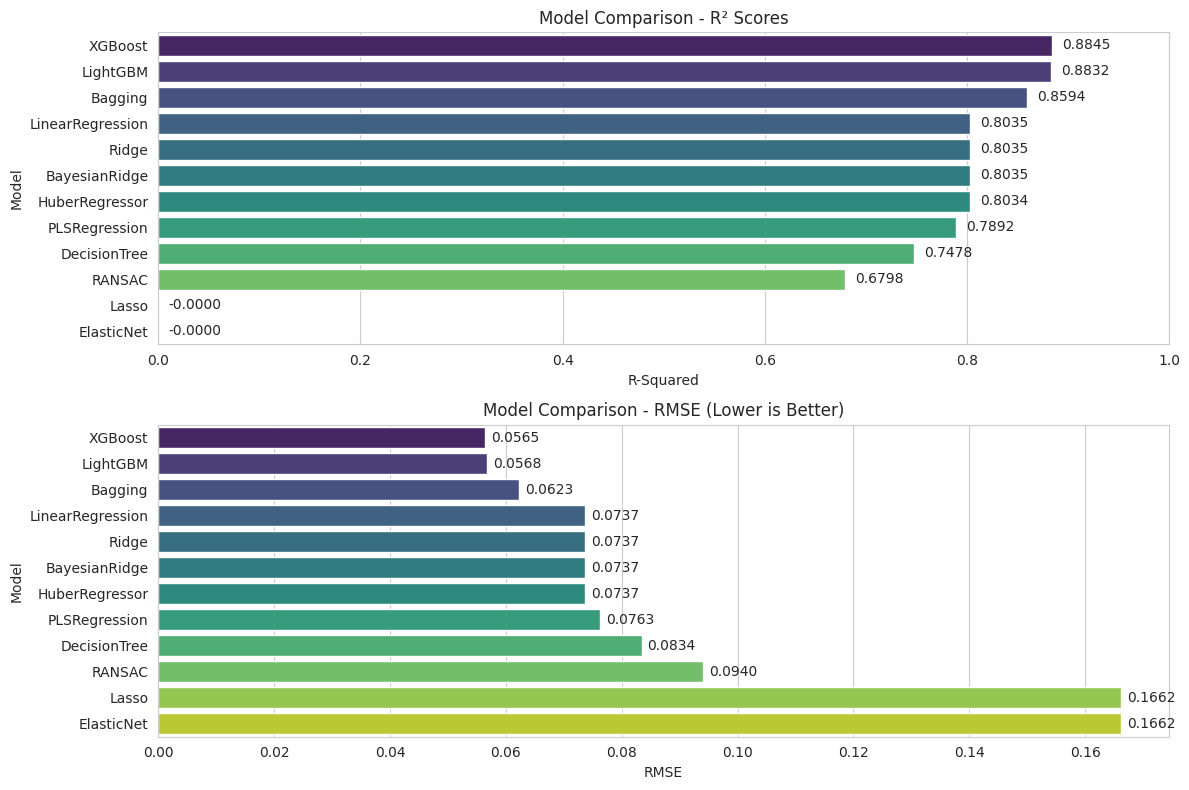

In [12]:
# Visualize results with value labels
plt.figure(figsize=(12, 8))

# Plot 1: R-squared scores
plt.subplot(2, 1, 1)
ax1 = sns.barplot(data=results_df, x="R-Squared", y="Model", hue="Model", palette="viridis", legend=False)
plt.title("Model Comparison - R² Scores")
plt.xlim(0, 1)

# Add value labels on bars
for i, v in enumerate(results_df["R-Squared"]):
    ax1.text(v + 0.01, i, f"{v:.4f}", va="center", fontweight="normal")

# Plot 2: RMSE values
plt.subplot(2, 1, 2)
ax2 = sns.barplot(data=results_df, x="RMSE", y="Model", hue="Model", palette="viridis", legend=False)
plt.title("Model Comparison - RMSE (Lower is Better)")

# Add value labels on bars
for i, v in enumerate(results_df["RMSE"]):
    ax2.text(v + 0.001, i, f"{v:.4f}", va="center", fontweight="normal")

plt.tight_layout()
plt.show()

## 7. Hyperparameter Tuning for Top 2 Models

### 7.1 XGBoost Tuning

In [13]:
# XGBoost parameter grid
xgb_param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1, 2],
    "reg_lambda": [1, 1.5, 2, 3, 5],
    "gamma": [0, 0.1, 0.2, 0.5, 1],
    "min_child_weight": [1, 3, 5, 7],
}
print("XGBoost Grid Search...")
print("=" * 45)

# Get original XGBoost performance
original_xgb_r2 = results_df[results_df["Model"] == "XGBoost"]["R-Squared"].iloc[0]

# Perform Grid Search
xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
    xgb_param_grid,
    n_iter=N_ITER_GRID_SEARCH,
    cv=CV_GRID_SEARCH,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
)

xgb_search.fit(X_train_processed, y_train)

# Store tuned model
trained_models["XGBoost_Tuned"] = xgb_search.best_estimator_

# Evaluate tuned model
y_val_pred_xgb = trained_models["XGBoost_Tuned"].predict(X_val_processed)
tuned_xgb_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
tuned_xgb_r2 = r2_score(y_val, y_val_pred_xgb)

# Get original RMSE for comparison
original_xgb_rmse = results_df[results_df["Model"] == "XGBoost"]["RMSE"].iloc[0]

print(f"\nXGBoost Tuning Complete!")
print(f"Best parameters: {xgb_search.best_params_}")
print(f"Original RMSE: {original_xgb_rmse:.4f}")
print(f"Tuned RMSE: {tuned_xgb_rmse:.4f}")
print(f"Improvement: {original_xgb_rmse - tuned_xgb_rmse:+.4f}")
print(f"R²: {tuned_xgb_r2:.4f}")

XGBoost Grid Search...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

XGBoost Tuning Complete!
Best parameters: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.7}
Original RMSE: 0.0565
Tuned RMSE: 0.0571
Improvement: -0.0007
R²: 0.8818


### 7.2 LightGBM Tuning

In [14]:
# LightGBM grid
lgb_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 5, 6, 7],
    "learning_rate": [0.05, 0.1, 0.15],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "num_leaves": [31, 40, 50, 63],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2],
    "min_child_samples": [10, 20, 30],
    "min_child_weight": [0.01, 0.1, 1],
    "min_split_gain": [0, 0.1],
}

print("LightGBM Grid Search...")
print("=" * 50)

# Get original model performance
original_lgb_r2 = results_df[results_df["Model"] == "LightGBM"]["R-Squared"].iloc[0]
original_lgb_rmse = results_df[results_df["Model"] == "LightGBM"]["RMSE"].iloc[0]
lgb_search = RandomizedSearchCV(
    LGBMRegressor(random_state=RANDOM_STATE, verbose=-1),
    lgb_param_grid,
    n_iter=N_ITER_GRID_SEARCH,
    cv=CV_GRID_SEARCH,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
)

lgb_search.fit(X_train_processed, y_train)

# Store tuned model
trained_models["LightGBM_Tuned"] = lgb_search.best_estimator_

# Evaluate tuned model
y_val_pred_lgb = trained_models["LightGBM_Tuned"].predict(X_val_processed)
tuned_lgb_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
tuned_lgb_r2 = r2_score(y_val, y_val_pred_lgb)

print(f"\nLightGBM Tuning Complete!")
print(f"Best parameters: {lgb_search.best_params_}")
print(f"Original RMSE: {original_lgb_rmse:.4f}")
print(f"Tuned RMSE: {tuned_lgb_rmse:.4f}")
print(f"Improvement: {original_lgb_rmse - tuned_lgb_rmse:+.4f}")
print(f"R²: {tuned_lgb_r2:.4f}")

LightGBM Grid Search...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END colsample_bytree=0.9, learning_rate=0.15, max_depth=6, min_child_samples=20, min_child_weight=1, min_split_gain=0.1, n_estimators=50, num_leaves=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time= 2.6min
[CV] END colsample_bytree=0.9, learning_rate=0.15, max_depth=6, min_child_samples=20, min_child_weight=1, min_split_gain=0.1, n_estimators=50, num_leaves=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time= 2.6min
[CV] END colsample_bytree=0.9, learning_rate=0.15, max_depth=6, min_child_samples=20, min_child_weight=1, min_split_gain=0.1, n_estimators=50, num_leaves=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time= 2.6min
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, min_child_samples=10, min_child_weight=0.1, min_split_gain=0.1, n_estimators=50, num_leaves=63, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time= 2.8min
[CV] END colsample_bytree=1.0

## 8. Ensemble Model - XGBoost + LightGBM Combination

In [15]:
# Create ensemble of tuned models
ensemble_models = [("xgb_tuned", trained_models["XGBoost_Tuned"]), ("lgb_tuned", trained_models["LightGBM_Tuned"])]

# Voting Regressor with equal weights
ensemble = VotingRegressor(estimators=ensemble_models, weights=None, n_jobs=-1)  # Equal weights

# Train ensemble on the same training data
print("Training ensemble model...")
ensemble.fit(X_train_processed, y_train)

# Store the ensemble model for later evaluation
trained_models["Ensemble_XGB_LGB"] = ensemble

print("Ensemble model created successfully!")

Training ensemble model...
Ensemble model created successfully!


In [16]:
print("Ensemble Validation Performance")
print("=" * 40)

# Evaluate only ensemble on validation set
y_val_pred_ensemble = trained_models["Ensemble_XGB_LGB"].predict(X_val_processed)

# Calculate metrics
val_r2 = r2_score(y_val, y_val_pred_ensemble)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_ensemble))


print(f"Ensemble XGB+LGB Validation Results:")
print(f"RMSE: {val_rmse:.4f}")
print(f"R²: {val_r2:.4f}")

Ensemble Validation Performance
Ensemble XGB+LGB Validation Results:
RMSE: 0.0568
R²: 0.8833


## 9. Final Evaluation on Test Set

In [17]:
# Models to evaluate
models_to_evaluate = {
    "XGBoost": trained_models["XGBoost"],
    "LightGBM": trained_models["LightGBM"],
    "XGBoost_Tuned": trained_models["XGBoost_Tuned"],
    "LightGBM_Tuned": trained_models["LightGBM_Tuned"],
    "Ensemble_XGB_LGB": trained_models["Ensemble_XGB_LGB"],
}

test_results = []

print("Evaluating models on test set...")
for name, model in models_to_evaluate.items():
    # Predict on test set
    y_test_pred = model.predict(X_test_processed)

    # Calculate metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    test_results.append({"Model": name, "Test_R2": test_r2, "Test_RMSE": test_rmse, "Test_MAE": test_mae})

# Create results dataframe
test_results_df = pd.DataFrame(test_results).sort_values("Test_RMSE")

print("\nFinal Test Set Performance (Sorted by RMSE):")
print("=" * 60)
display(test_results_df)

Evaluating models on test set...

Final Test Set Performance (Sorted by RMSE):


,Model,Test_R2,Test_RMSE,Test_MAE
0,XGBoost,0.8844,0.0563,0.0439
4,Ensemble_XGB_LGB,0.8832,0.0566,0.0442
3,LightGBM_Tuned,0.8832,0.0566,0.0442
1,LightGBM,0.8832,0.0567,0.0442
2,XGBoost_Tuned,0.8819,0.0570,0.0445


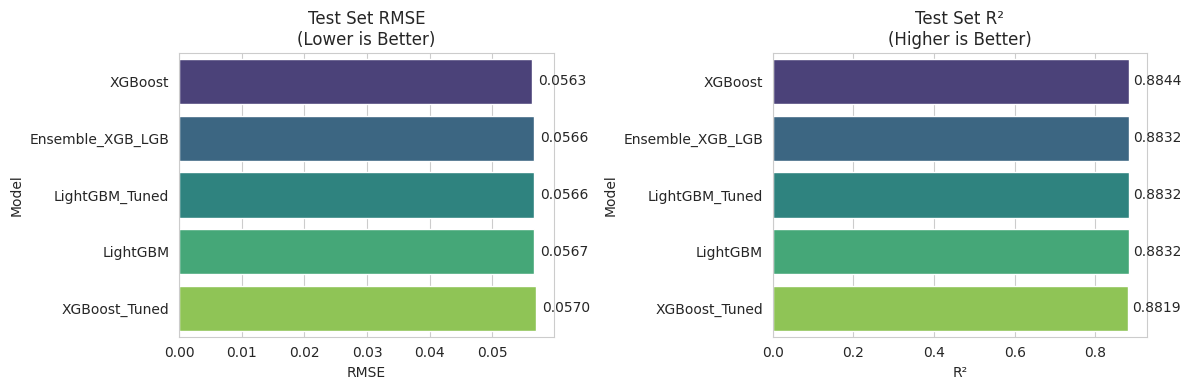

In [18]:
# Visualize results
plt.figure(figsize=(12, 4))

# Plot 1: RMSE comparison
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=test_results_df, x='Test_RMSE', y='Model', hue='Model', palette='viridis', legend=False)
plt.title('Test Set RMSE\n(Lower is Better)')
plt.xlabel('RMSE')
# Add value labels
for i, v in enumerate(test_results_df['Test_RMSE']):
    ax1.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='normal')

# Plot 2: R² comparison  
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=test_results_df, x='Test_R2', y='Model', hue='Model', palette='viridis', legend=False)
plt.title('Test Set R²\n(Higher is Better)')
plt.xlabel('R²')
# Add value labels
for i, v in enumerate(test_results_df['Test_R2']):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='normal')

plt.tight_layout()
plt.show()

In [19]:
# Summary
best_model = test_results_df.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"📊 Test RMSE: {best_model['Test_RMSE']:.4f}")
print(f"📈 Test R²: {best_model['Test_R2']:.4f}")


🏆 Best Model: XGBoost
📊 Test RMSE: 0.0563
📈 Test R²: 0.8844


## 10. Create Kaggle Submission File

In [ ]:
# Get the best model from test results
best_model_name = test_results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]

print(f"Using best model: {best_model_name}")
print(f"Test RMSE: {test_results_df.iloc[0]['Test_RMSE']:.4f}")
print(f"Test R²: {test_results_df.iloc[0]['Test_R2']:.4f}")

# Make predictions on Kaggle test set
kaggle_predictions = best_model.predict(X_kaggle_processed)

# Create submission dataframe
submission_df = pd.DataFrame({"id": kaggle_test_df.index, "accident_risk": kaggle_predictions})

# Ensure predictions are in valid range [0, 1]
submission_df["accident_risk"] = submission_df["accident_risk"].clip(0, 1)

# Save to CSV
submission_df.to_csv("submission.csv", index=False)

print(f"\n✅ Submission file created:")
print(f"📊 Predictions range: [{submission_df['accident_risk'].min():.4f}, {submission_df['accident_risk'].max():.4f}]")
print(f"📁 File saved with {len(submission_df)} predictions")

# Show sample of submission
print("\nSample of submission file:")
display(submission_df.head(10))

Using best model: XGBoost
Test RMSE: 0.0563
Test R²: 0.8844

✅ Submission file created:
📊 Predictions range: [0.0000, 0.8908]
📁 File saved with 172585 predictions

Sample of submission file:


,id,accident_risk
0,517754,0.2857
1,517755,0.1224
2,517756,0.1865
3,517757,0.3275
4,517758,0.4179
5,517759,0.4583
6,517760,0.2581
7,517761,0.2002
8,517762,0.3630
9,517763,0.3203
